In [ ]:
import matplotlib
matplotlib.use('Qt5Agg')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
from ultralytics import YOLO
import matplotlib
matplotlib.use('Qt5Agg')
# Load YOLO model
model_yolo = YOLO('yolov8m-pose.pt')

# Open video file
cap = cv2.VideoCapture(0)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define codec and create VideoWriter object
output_file = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Lists to store tracked keypoint positions
trackpoint1 = []
trackpoint2 = []

# Colors for each keypoint (in BGR format)
color1 = (255, 0, 0)  # Blue
color2 = (0, 255, 0)  # Green

# Initialize variables for angle threshold tracking
angle_threshold = 95
below_threshold_count = 0
prev_angle = None

# Set up the matplotlib figure and subplots for real-time plotting (vertically stacked)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
lines1, = axes[0].plot([], [], 'b', label='X coordinates')
lines1_y, = axes[0].plot([], [], 'r', label='Y coordinates')
lines2, = axes[1].plot([], [], 'b', label='X coordinates')
lines2_y, = axes[1].plot([], [], 'r', label='Y coordinates')

axes[0].set_xlim(0, 1000)  # Set to the expected range of steps
axes[0].set_ylim(0, frame_height)
axes[0].set_title('Knee Coordinates vs Time Steps')
axes[0].legend()

axes[1].set_xlim(0, 1000)
axes[1].set_ylim(0, frame_height)
axes[1].set_title('Hips Coordinates vs Time Steps')
axes[1].legend()

plt.tight_layout()

# Initialize step counter
step = 0

def calculate_angle(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    return abs(angle_degrees)

def update_plot(i):
    global step, below_threshold_count,  prev_angle

    ret, frame = cap.read()
    if not ret:
        print("Reached end of video.")
        return

    # Perform YOLO detection
    results = model_yolo(frame, stream=False, show=False)
    for result in results:
        keypoints = result.keypoints.xy  # Keypoints object for pose outputs
        matrix = np.asarray(keypoints[0])

        # Draw all keypoints on the frame
        for point in matrix:
            if not np.array_equal(point, [0, 0]):
                cv2.circle(frame, (int(point[0]), int(point[1])), 3, (255, 255, 255), -1)  # White for all keypoints

        # Ensure matrix has enough keypoints before accessing the desired keypoints
        if len(matrix) > 16:
            point1 = matrix[13]
            point2 = matrix[11]
            
            if not np.array_equal(point1, [0, 0]):
                trackpoint1.append((step, point1[0], point1[1]))
            if not np.array_equal(point2, [0, 0]):
                trackpoint2.append((step, point2[0], point2[1]))

    # Draw colored dots and lines for each tracked keypoint
    for i in range(1, len(trackpoint1)):
        pt1 = (int(trackpoint1[i-1][1]), int(trackpoint1[i-1][2]))
        pt2 = (int(trackpoint1[i][1]), int(trackpoint1[i][2]))
        cv2.circle(frame, pt2, 3, color1, -1)  # Draw dot
        cv2.line(frame, pt1, pt2, color1, 2)  # Draw line

    for i in range(1, len(trackpoint2)):
        pt1 = (int(trackpoint2[i-1][1]), int(trackpoint2[i-1][2]))
        pt2 = (int(trackpoint2[i][1]), int(trackpoint2[i][2]))
        cv2.circle(frame, pt2, 3, color2, -1)  # Draw dot
        cv2.line(frame, pt1, pt2, color2, 2)  # Draw line

    # Calculate the absolute angle between the two points
    if len(trackpoint1) > 0 and len(trackpoint2) > 0:
        x1, y1 = trackpoint1[-1][1], trackpoint1[-1][2]
        x2, y2 = trackpoint2[-1][1], trackpoint2[-1][2]
        angle = calculate_angle(x1, y1, x2, y2)

        # Check for transition from high value to below threshold
        if prev_angle is not None and prev_angle >= angle_threshold and angle < angle_threshold:
            below_threshold_count += 1
            below_threshold_start_time = None

        # Update the previous angle
        prev_angle = angle

        # Display the angle and count
        cv2.putText(frame, f"Angle: {angle:.2f} degrees", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Count: {below_threshold_count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Save the frame to the output video
    out.write(frame)

    # Update plots
    if trackpoint1:
        steps1, x_coords1, y_coords1 = zip(*trackpoint1)
        lines1.set_data(steps1, x_coords1)
        lines1_y.set_data(steps1, y_coords1)

    if trackpoint2:
        steps2, x_coords2, y_coords2 = zip(*trackpoint2)
        lines2.set_data(steps2, x_coords2)
        lines2_y.set_data(steps2, y_coords2)

    # Display the frame with keypoints and connecting lines
    cv2.imshow('Video1', frame)

    step += 1

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(25) & 0xFF == ord('q'):
        plt.close('all')
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        exit()

# Create the animation
#ani = FuncAnimation(fig, update_plot, frames=range(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))), interval=10)
ani = FuncAnimation(fig, update_plot, interval=10)

# Display the plot
plt.show()

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


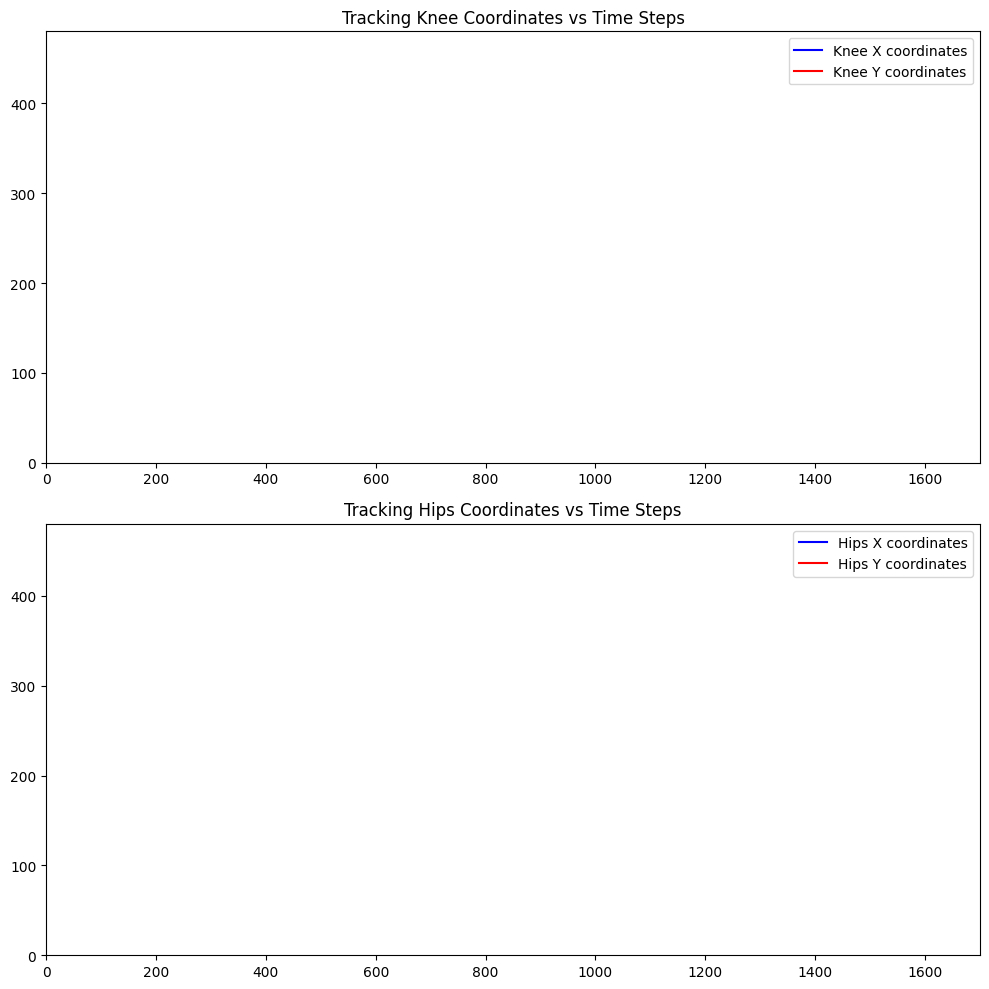

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
from ultralytics import YOLO

# Load YOLO model
model_yolo = YOLO('yolov8m-pose.pt')

# Open video file
cap = cv2.VideoCapture(0)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define codec and create VideoWriter object
output_file = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Lists to store tracked keypoint positions
trackpoint1 = []
trackpoint2 = []

# Colors for each keypoint (in BGR format)
color1 = (255, 0, 0)  # Blue
color2 = (0, 255, 0)  # Green

# Initialize variables for angle threshold tracking
angle_threshold = 90
below_threshold_count = 0
prev_angle = None

# Set up the matplotlib figure and subplots for real-time plotting (vertically stacked)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
lines1, = axes[0].plot([], [], 'b', label='Knee X coordinates')
lines1_y, = axes[0].plot([], [], 'r', label='Knee Y coordinates')
lines2, = axes[1].plot([], [], 'b', label='Hips X coordinates')
lines2_y, = axes[1].plot([], [], 'r', label='Hips Y coordinates')

# Set up the plot axis limits
axes[0].set_xlim(0, 1700)  # Set to the expected range of steps
axes[0].set_ylim(0, frame_height)
axes[0].set_title('Tracking Knee Coordinates vs Time Steps')
axes[0].legend()  # Add legend to the first subplot

axes[1].set_xlim(0, 1700)
axes[1].set_ylim(0, frame_height)
axes[1].set_title('Tracking Hips Coordinates vs Time Steps')
axes[1].legend()  # Add legend to the second subplot

plt.tight_layout()

# Initialize step counter
step = 0

def calculate_angle(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    return abs(angle_degrees)

def update_plot(i):
    global step, below_threshold_count, prev_angle

    ret, frame = cap.read()
    if not ret:
        print("Reached end of video.")
        return

    # Perform YOLO detection
    results = model_yolo(frame, stream=False, show=False)
    for result in results:
        keypoints = result.keypoints.xy  # Keypoints object for pose outputs
        matrix = np.asarray(keypoints[0])

        # Draw all keypoints on the frame
        for point in matrix:
            if not np.array_equal(point, [0, 0]):
                cv2.circle(frame, (int(point[0]), int(point[1])), 3, (255, 255, 255), -1)  # White for all keypoints

        # Ensure matrix has enough keypoints before accessing the desired keypoints
        if len(matrix) > 16:
            point1 = matrix[13]
            point2 = matrix[11]

            if not np.array_equal(point1, [0, 0]):
                trackpoint1.append((step, point1[0], point1[1]))
            if not np.array_equal(point2, [0, 0]):
                trackpoint2.append((step, point2[0], point2[1]))

    # Draw colored dots and lines for each tracked keypoint
    for i in range(1, len(trackpoint1)):
        pt1 = (int(trackpoint1[i-1][1]), int(trackpoint1[i-1][2]))
        pt2 = (int(trackpoint1[i][1]), int(trackpoint1[i][2]))
        cv2.circle(frame, pt2, 3, color1, -1)  # Draw dot
        cv2.line(frame, pt1, pt2, color1, 2)  # Draw line

    for i in range(1, len(trackpoint2)):
        pt1 = (int(trackpoint2[i-1][1]), int(trackpoint2[i-1][2]))
        pt2 = (int(trackpoint2[i][1]), int(trackpoint2[i][2]))
        cv2.circle(frame, pt2, 3, color2, -1)  # Draw dot
        cv2.line(frame, pt1, pt2, color2, 2)  # Draw line

    # Calculate the absolute angle between the two points
    if len(trackpoint1) > 0 and len(trackpoint2) > 0:
        x1, y1 = trackpoint1[-1][1], trackpoint1[-1][2]
        x2, y2 = trackpoint2[-1][1], trackpoint2[-1][2]
        angle = calculate_angle(x1, y1, x2, y2)

        # Check for transition from high value to below threshold
        if prev_angle is not None and prev_angle >= angle_threshold and angle < angle_threshold:
            below_threshold_count += 1

        # Update the previous angle
        prev_angle = angle

        # Display the angle and count
        cv2.putText(frame, f"Angle: {angle:.2f} degrees", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        #cv2.putText(frame, f"Count: {below_threshold_count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Save the frame to the output video
    out.write(frame)

    # Update plots
    if trackpoint1:
        steps1, x_coords1, y_coords1 = zip(*trackpoint1)
        lines1.set_data(steps1, x_coords1)
        lines1_y.set_data(steps1, y_coords1)

    if trackpoint2:
        steps2, x_coords2, y_coords2 = zip(*trackpoint2)
        lines2.set_data(steps2, x_coords2)
        lines2_y.set_data(steps2, y_coords2)

    # Display the frame with keypoints and connecting lines
    resized_frame = cv2.resize(frame, (int(frame_width * 1.9 ), int(frame_height * 1.5)))
    cv2.imshow('Video1', resized_frame)

    step += 1

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(25) & 0xFF == ord('q'):
        plt.close('all')
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        exit()

# Create the animation
ani = FuncAnimation(fig, update_plot, frames=range(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))), interval=10)

# Display the plot
plt.show()

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


In [2]:
import matplotlib
matplotlib.use('Qt5Agg')
import cv2
import numpy as np
import math
from ultralytics import YOLO

# Load YOLO model
model_yolo = YOLO('yolov8m-pose.pt')

# Open video file
cap = cv2.VideoCapture(0)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define codec and create VideoWriter object
output_file = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Initialize variables for angle threshold tracking
angle_threshold = 95
below_threshold_count = 0
prev_angle = None

# Lists to store tracked keypoint positions
trackpoint1 = []
trackpoint2 = []

# Colors for each keypoint (in BGR format)
color1 = (255, 0, 0)  # Blue
color2 = (0, 255, 0)  # Green

def calculate_angle(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    return abs(angle_degrees)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Reached end of video.")
        break

    # Perform YOLO detection
    results = model_yolo(frame, stream=False, show=False)
    for result in results:
        keypoints = result.keypoints.xy  # Keypoints object for pose outputs
        matrix = np.asarray(keypoints[0])

        # Draw all keypoints on the frame
        for point in matrix:
            if not np.array_equal(point, [0, 0]):
                cv2.circle(frame, (int(point[0]), int(point[1])), 3, (255, 255, 255), -1)  # White for all keypoints

        # Ensure matrix has enough keypoints before accessing the desired keypoints
        if len(matrix) > 16:
            point1 = matrix[13]
            point2 = matrix[11]

            if not np.array_equal(point1, [0, 0]):
                trackpoint1.append((len(trackpoint1), point1[0], point1[1]))
            if not np.array_equal(point2, [0, 0]):
                trackpoint2.append((len(trackpoint2), point2[0], point2[1]))

    # Draw colored dots and lines for each tracked keypoint
    for i in range(1, len(trackpoint1)):
        pt1 = (int(trackpoint1[i-1][1]), int(trackpoint1[i-1][2]))
        pt2 = (int(trackpoint1[i][1]), int(trackpoint1[i][2]))
        cv2.circle(frame, pt2, 3, color1, -1)  # Draw dot
        cv2.line(frame, pt1, pt2, color1, 2)  # Draw line

    for i in range(1, len(trackpoint2)):
        pt1 = (int(trackpoint2[i-1][1]), int(trackpoint2[i-1][2]))
        pt2 = (int(trackpoint2[i][1]), int(trackpoint2[i][2]))
        cv2.circle(frame, pt2, 3, color2, -1)  # Draw dot
        cv2.line(frame, pt1, pt2, color2, 2)  # Draw line

    # Calculate the absolute angle between the two points
    if len(trackpoint1) > 0 and len(trackpoint2) > 0:
        x1, y1 = trackpoint1[-1][1], trackpoint1[-1][2]
        x2, y2 = trackpoint2[-1][1], trackpoint2[-1][2]
        angle = calculate_angle(x1, y1, x2, y2)

        # Check for transition from high value to below threshold
        if prev_angle is not None and prev_angle >= angle_threshold and angle < angle_threshold:
            below_threshold_count += 1

        # Update the previous angle
        prev_angle = angle

        # Display the angle and count
        cv2.putText(frame, f"Angle: {angle:.2f} degrees", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Count: {below_threshold_count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Resize the frame to increase display size
    resized_frame = cv2.resize(frame, (int(frame_width * 1.5), int(frame_height * 1.5)))

    # Display the frame with keypoints and connecting lines
    cv2.imshow('Video1', resized_frame)

    # Save the frame to the output video
    out.write(frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()



0: 480x640 1 person, 174.0ms
Speed: 2.2ms preprocess, 174.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 182.8ms
Speed: 1.5ms preprocess, 182.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 144.9ms
Speed: 1.2ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 148.8ms
Speed: 1.2ms preprocess, 148.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 158.7ms
Speed: 1.1ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 142.4ms
Speed: 1.1ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 142.0ms
Speed: 1.1ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 142.0ms
Speed: 1.2ms preprocess, 142.0ms inference, 0.9ms postprocess per image at


0: 640x384 1 person, 639.3ms
Speed: 0.0ms preprocess, 639.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 629.5ms
Speed: 0.0ms preprocess, 629.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 629.5ms
Speed: 0.0ms preprocess, 629.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 629.8ms
Speed: 0.0ms preprocess, 629.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 644.9ms
Speed: 0.0ms preprocess, 644.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 661.2ms
Speed: 0.0ms preprocess, 661.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 630.4ms
Speed: 0.0ms preprocess, 630.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 629.6ms
Speed: 0.0ms preprocess, 629.6ms inference, 0.0ms postprocess per image at

### angle

In [1]:
import matplotlib
matplotlib.use('Qt5Agg')
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
from ultralytics import YOLO

# Load YOLO model
model_yolo = YOLO('yolov8m-pose.pt')

# Open video file
cap = cv2.VideoCapture(0)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define codec and create VideoWriter object
output_file = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Lists to store tracked keypoint positions
trackpoint1 = []
trackpoint2 = []
trackpoint3 = []

# Colors for each keypoint (in BGR format)
color1 = (255, 0, 0)    # Blue
color2 = (0, 255, 0)    # Green
color3 = (0, 0, 255)    # Red

# Initialize variables for angle threshold tracking
angle_threshold = 90
below_threshold_count = 0
prev_angle = None

# Set up the matplotlib figure and subplots for real-time plotting (vertically stacked)
fig, axes = plt.subplots(3, 1, figsize=(8, 12))  # Three subplots for three points

# Plot lines for Point1
lines1_x, = axes[0].plot([], [], 'b', label=' Tracking Wrist X Coordinate')
lines1_y, = axes[0].plot([], [], 'c', label='Tracking Wrist Y Coordinate')

# Plot lines for Point2
lines2_x, = axes[1].plot([], [], 'g', label='Tracking Elbow  X Coordinate')
lines2_y, = axes[1].plot([], [], 'm', label='Tracking Elbow Y Coordinate')

# Plot lines for Point3
lines3_x, = axes[2].plot([], [], 'r', label='Tracking Shoulder  X Coordinate')
lines3_y, = axes[2].plot([], [], 'y', label='Tracking Shoulder Y Coordinate')

# Set up the plot axis limits for each subplot
for ax in axes:
    ax.set_xlim(0, 1700)  # Adjust based on expected number of steps
    ax.set_ylim(0, frame_height)
    ax.legend()
    ax.grid(True)

axes[0].set_title('Tracking Wrist Coordinates vs Time Steps')
axes[1].set_title('Tracking Elbow Coordinates vs Time Steps')
axes[2].set_title('Tracking Shoulder Coordinates vs Time Steps')

plt.tight_layout()

# Initialize step counter
step = 0

def calculate_angle(x1, y1, x2, y2):
    """
    Calculate the absolute angle in degrees between two points.
    """
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    return abs(angle_degrees)

def update_plot(frame_number):
    global step, below_threshold_count, prev_angle

    ret, frame = cap.read()
    if not ret:
        print("Reached end of video.")
        plt.close(fig)  # Close the plot when video ends
        return

    # Perform YOLO detection
    results = model_yolo(frame, stream=False, show=False)
    for result in results:
        keypoints = result.keypoints.xy  # Keypoints object for pose outputs
        if keypoints is None or len(keypoints) == 0:
            continue
        matrix = np.asarray(keypoints[0])

        # Draw all keypoints on the frame
        for point in matrix:
            if not np.array_equal(point, [0, 0]):
                cv2.circle(frame, (int(point[0]), int(point[1])), 3, (255, 255, 255), -1)  # White for all keypoints

        # Ensure matrix has enough keypoints before accessing the desired keypoints
        if len(matrix) > 16:
            point1 = matrix[10]  # Example keypoint index for Point1
            point2 = matrix[8]  # Example keypoint index for Point2
            point3 = matrix[6]  # Example keypoint index for Point3

            if not np.array_equal(point1, [0, 0]):
                trackpoint1.append((step, point1[0], point1[1]))
            if not np.array_equal(point2, [0, 0]):
                trackpoint2.append((step, point2[0], point2[1]))
            if not np.array_equal(point3, [0, 0]):
                trackpoint3.append((step, point3[0], point3[1]))

    # Draw colored dots and lines for each tracked keypoint
    for idx, (track, color) in enumerate(zip([trackpoint1, trackpoint2, trackpoint3], [color1, color2, color3])):
        for j in range(1, len(track)):
            pt1 = (int(track[j-1][1]), int(track[j-1][2]))
            pt2 = (int(track[j][1]), int(track[j][2]))
            cv2.circle(frame, pt2, 3, color, -1)  # Draw dot
            cv2.line(frame, pt1, pt2, color, 2)  # Draw line

    # Calculate the absolute angle between two points (e.g., point1 and point2)
    if len(trackpoint1) > 0 and len(trackpoint2) > 0:
        x1, y1 = trackpoint1[-1][1], trackpoint1[-1][2]
        x2, y2 = trackpoint2[-1][1], trackpoint2[-1][2]
        angle = calculate_angle(x1, y1, x2, y2)

        # Check for transition from high value to below threshold
        if prev_angle is not None and prev_angle >= angle_threshold and angle < angle_threshold:
            below_threshold_count += 1

        # Update the previous angle
        prev_angle = angle

        # Display the angle and count on the frame
        cv2.putText(frame, f"Angle: {angle:.2f} degrees", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        #cv2.putText(frame, f"Count: {below_threshold_count}", (50, 100),
                    #cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Save the frame to the output video
    out.write(frame)

    # Update plots for each tracked point
    if trackpoint1:
        steps1, x_coords1, y_coords1 = zip(*trackpoint1)
        lines1_x.set_data(steps1, x_coords1)
        lines1_y.set_data(steps1, y_coords1)

    if trackpoint2:
        steps2, x_coords2, y_coords2 = zip(*trackpoint2)
        lines2_x.set_data(steps2, x_coords2)
        lines2_y.set_data(steps2, y_coords2)

    if trackpoint3:
        steps3, x_coords3, y_coords3 = zip(*trackpoint3)
        lines3_x.set_data(steps3, x_coords3)
        lines3_y.set_data(steps3, y_coords3)

    # Redraw the plot
    for ax in axes:
        ax.relim()
        ax.autoscale_view()

    # Display the frame with keypoints and connecting lines
    resized_frame = cv2.resize(frame, (int(frame_width * 1.9), int(frame_height * 1.5)))
    cv2.imshow('Video1', resized_frame)

    step += 1

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        plt.close(fig)
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        exit()

# Create the animation
#ani = FuncAnimation(fig, update_plot, frames=range(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))), interval=30, repeat=False)
ani = FuncAnimation(fig, update_plot, interval=10)

# Display the plot
plt.show()
plt.savefig('final_plot.png')  # Save the figure as a PNG file

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


C:\Users\peter.forcha\AppData\Local\Temp\ipykernel_24560\2050747071.py:189: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update_plot, interval=10)



0: 480x640 1 person, 175.2ms
Speed: 2.6ms preprocess, 175.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 153.3ms
Speed: 1.7ms preprocess, 153.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 152.2ms
Speed: 1.2ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 155.9ms
Speed: 1.2ms preprocess, 155.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 154.5ms
Speed: 1.0ms preprocess, 154.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 152.2ms
Speed: 1.0ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 162.9ms
Speed: 0.9ms preprocess, 162.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 163.4ms
Speed: 1.1ms preprocess, 163.4ms inference, 0.9ms postprocess per image at

AttributeError: 'NoneType' object has no attribute 'interval'

AttributeError: 'IPythonKernel' object has no attribute 'app'

In [ ]:
plt.show()

## Masking

In [ ]:
from collections import defaultdict
import cv2
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# Load the YOLO model with segmentation capabilities
model = YOLO("yolov8n-seg.pt")

# Open the video file
cap = cv2.VideoCapture(0)

# Retrieve video properties: width, height, and frames per second
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Initialize video writer to save the output video with the specified properties
out = cv2.VideoWriter("instance-segmentation-object-tracking.avi", cv2.VideoWriter_fourcc(*"MJPG"), fps, (w, h))

# Define the region where the ID change should occur (e.g., bottom-right quarter of the frame)
region_x1, region_y1 = int(w * 0.75), int(h * 0.75)
region_x2, region_y2 = int(w * 0.5), h

# Define a mapping for changed IDs
changed_ids = set()

while True:
    # Read a frame from the video
    ret, im0 = cap.read()
    if not ret:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    # Create an annotator object to draw on the frame
    annotator = Annotator(im0, line_width=2)

    # Perform object tracking on the current frame
    results = model.track(im0, persist=True)

    # Check if tracking IDs and masks are present in the results
    if results[0].boxes.id is not None and results[0].masks is not None:
        # Extract masks and tracking IDs
        masks = results[0].masks.xy
        track_ids = results[0].boxes.id.int().cpu().tolist()
        boxes = results[0].boxes.xyxy.int().cpu().tolist()

        # Annotate each mask with its corresponding tracking ID and color
        for mask, track_id, box in zip(masks, track_ids, boxes):
            x1, y1, x2, y2 = box

            # Check if the object is within the defined region
            if region_x1 <= (x1 + x2) // 2 <= region_x2 and region_y1 <= (y1 + y2) // 2 <= region_y2:
                changed_ids.add(track_id)

            # Change the ID to "washed" if the ID is in the changed_ids set
            display_id = "washed" if track_id in changed_ids else str(track_id)

            annotator.seg_bbox(mask=mask, mask_color=colors(track_id, True), track_label=display_id)

    # Draw the defined region on the frame
    cv2.rectangle(im0, (region_x1, region_y1), (region_x2, region_y2), (0, 255, 0), 2)
    
    # Write the annotated frame to the output video
    out.write(im0)
    # Display the annotated frame
    cv2.imshow("instance-segmentation-object-tracking", im0)

    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the video writer and capture objects, and close all OpenCV windows
out.release()
cap.release()
cv2.destroyAllWindows()
